# Elimination Algorithm
In this exercise, we will be experimenting with the Multi-armed bandit problem with the Elimination algorithm described in chapter 6 in the textbook.

## Setup
Consider an unstructured bandit problem. Suppose that we have $k$ arms, each with a random reward at time $t$ given by $rew[t] = avg[t] + \epsilon[t]$ where $\epsilon[t]$ is drawn from an i.i.d. Gaussian distribution whose variance is $0.01$. Note that we only require $\epsilon[t]$ to be sub-Gaussian for the analysis to go through.

The following code should be implemented to capture this setup.

# Reward function
Question: Implement the reward function described in the setup. Specifically, given a $k$- dimensional vector 'avg', return $k$- dimensional vector 'rew' such that $rew[t] = avg[t] + \epsilon[t]$ where $\epsilon[t] \sim \mathcal{N}(0,0.01 \times I)$ where $I$ is the identity matrix of size $k \times k$.

In [1]:
def get_reward(avg):
#     np.random.seed(0)
    k = len(avg)    
    rew = avg + np.random.multivariate_normal(np.zeros(k),0.01*np.identity(k))
    return rew

## Algorithm review
Recall there are three parameters of interest in the Elimination algoritm: $(n, k, m_l),$ where $n$ is the time horizon, $k$ is the number of arms, and $m_l$ is an algorithm parameter. Please refer to the text book (Algorithm 2 page 98) for details.\
The parameter to set: $m_l$ which is the number of times arm $i \in A_l$ is chosen during epoch $l$ where $A_l$ is the active set.

## Goal of this exercise
Implement the following using the template provided below. Please use the variable names suggested in the comments.
1. Basic Elimination algorithm implementation
2. Plot the expected cumulative regret of the Elimination algorithm vs. horizon ($n$).
3. The cumulative regret is expected to be logarithmic against the horizon. To check that this is case, plot the logarithm of the expected cumulative regret of the Elimination algorithm vs. horizon ($n$). (Hint: use the semilogx function in matplotlib.pyplot) 

# Import Dependencies

In [2]:
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt

## Elimination algorithm
Question: \
Implement Elimination algorithm using the skeleton below. The initialization part is done. Fill out the rest of the skeleton.

In [3]:
class Elimination():
    def __init__(self, avg, num_iter ): ## Initialization

        self.means = avg
        self.num_iter = num_iter
        self.num_arms = avg.size
        self.best_arm = np.argmax(avg)
        self.time = 0.0
        self.A = np.arange(self.num_arms)
        self.cum_reg = [0]
        self.m = np.ceil( 2 ** (2 * self.time) * np.log(max(np.exp(1), self.num_arms * self.num_iter * 2 ** (-2 * self.time))))
        self.iter = 0
        self.restart() 
    ## variable names (most are self explanatory)
    ## self.num_arms is the number of arms (k)
    ## self.means[arm] is the vector of true means of the arms
    ## self.time is the current time index: 1,....,num_iterations (this is t in the description at the top of this page)
    ## self.best_arm is the best arm given the true mean rewards
    ## self.cum_reg is the cumulative regret
    ## self.emp_means[arm] is the vector of empirical means of arms computed using the samples from epoch l
    ## self.num_pulls[arm] is the vector of number of times that arm k has been pulled during epoch l
    ## self.A is the active set in epoch l
    ## self.time2 is the time index in epoch l i.e: it goes from 1,..., m_l * size(self.A)
    ## self.m is the number of times to pull each arm in the active set in epoch l


    def restart(self): ## Restart the algorithm: Reset self.time2 to zero (done)
                     ## Set the values of the empirical means and number of pulls to zero.
        self.time2 = 0.0
        self.emp_means = np.zeros(self.num_arms)
        self.num_pulls = np.zeros(self.num_arms)
  
    def get_best_arm(self): ## For each time index in epoch l, find the best arm according to e-greedy 
        return self.A[int(self.time2 % len(self.A))]

    
    
    def update_stats(self, rew, arm): ## Update the empirical means, the number of pulls, and increment self.time2
        self.num_pulls[arm] += 1
        self.emp_means[arm] = (self.emp_means[arm] * self.num_pulls[arm] + rew) / (self.num_pulls[arm] + 1 )
        self.time2 += 1


    def update_elim(self): ## Update the active set
        self.m = np.ceil( 2 ** (2 * self.time) * np.log(max(np.exp(1), self.num_arms * self.num_iter * 2 ** (-2 * self.time))) )

        max_mean = np.amax(self.emp_means)
        elim_bound = 1 / (2**self.time)
        new_A = []
        for arm in self.A:
            if self.emp_means[arm] + elim_bound >= max_mean:
                new_A.append(arm)

        self.A = np.asarray(new_A)
    
    
    def update_reg(self,rew_vec,arm): ## Update the cumulative regret
        self.cum_reg.append(self.cum_reg[int(self.iter)] + (rew_vec[self.best_arm] - rew_vec[arm]))

    
    def iterate(self, rew_vec): ## Iterate the algorithm
        arm = self.get_best_arm()

        self.update_reg(rew_vec, arm)
        self.update_stats(rew_vec[arm], arm)
        self.iter += 1


# Experiment Function

The following code runs the Elimination algorithm for multiple instances. In the code below, num_inst is the number of instances, and num_iter is the time horizon.

In [4]:
def run_algo(avg, num_iter, num_inst):
    reg = np.zeros((num_inst, num_iter))
    
    for k in range(num_inst):
        algo = Elimination(avg, num_iter)

        if (k+1) % 10 == 0:
            print('Instance number = ', k+1)

        while len(algo.cum_reg) <= num_iter:
            if len(algo.cum_reg) >= num_iter:
                break 

            for t in range(int(algo.m) * algo.A.size):
                if len(algo.cum_reg) >= num_iter:
                    break 
                else:
                    rew_vec = get_reward(avg)
                    algo.iterate(rew_vec)            

            algo.update_elim()
            algo.restart()
            algo.time += 1

        reg[k, :] = np.asarray(algo.cum_reg)

    return reg

# Initializations

Use the following to initialize your algorithm. The value of $k$ is implicitly set to $5$ in the initialization below. (This vector contains the actual mean rewards).

In [5]:
avg = np.asarray([0.8, 0.88, 0.5, 0.7, 0.65])
num_iter,num_inst = int(1500),250

# Run Experiment

In [6]:
reg = run_algo(avg, num_iter, num_inst)

Instance number =  10
Instance number =  20
Instance number =  30
Instance number =  40
Instance number =  50
Instance number =  60
Instance number =  70
Instance number =  80
Instance number =  90
Instance number =  100
Instance number =  110
Instance number =  120
Instance number =  130
Instance number =  140
Instance number =  150
Instance number =  160
Instance number =  170
Instance number =  180
Instance number =  190
Instance number =  200
Instance number =  210
Instance number =  220
Instance number =  230
Instance number =  240
Instance number =  250


## Plotting the Results
Questions: \
1 - Compute the average regret over the number of instances and plot it against the horizon. Label the x-axis as time, and the y-axis as Cumulative Regret. Add a caption labeling this as 'Cumulative Regret with Eliminiation Algorithm.

2 - Use the semilogx function in matplotlib to check that the regret is logarithmic against horizon.

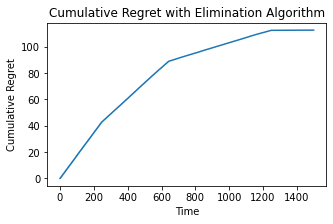

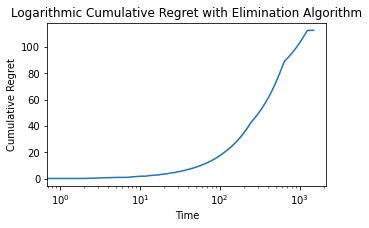

In [7]:
# Compute the average regret over the number of instances
avg_regret = np.mean(reg, axis=0)

# Plot the average cumulative regret against horizon
plt.figure(figsize=(5, 3))
plt.plot(range(num_iter), avg_regret)
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret with Elimination Algorithm')
plt.show()

# Plot the average cumulative regret using semilogx to check if it's logarithmic against horizon
plt.figure(figsize=(5, 3))
plt.semilogx(range(num_iter), avg_regret)
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Logarithmic Cumulative Regret with Elimination Algorithm')
plt.show()